In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import shutil
import warnings
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import optuna
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from liquidnet.main import LiquidNet
import random

In [2]:
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [4]:
df = pd.read_excel("../datasets/AEP_hourly_processed.xlsx")
df = df.drop(columns=["Unnamed: 0"], errors="ignore")
df["Datetime"] = pd.to_datetime(df["Datetime"])
df = df.sort_values("Datetime")
df.set_index("Datetime", inplace=True)
df = df[["AEP_MW"]]
df = df.iloc[:5000]

train_size = int(len(df) * 0.8)
df_train_raw = df.iloc[:train_size]
df_test_raw = df.iloc[train_size:]

scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(df_train_raw)
scaled_test = scaler.transform(df_test_raw)

df_train = pd.DataFrame(scaled_train, columns=df.columns, index=df_train_raw.index)
df_test = pd.DataFrame(scaled_test, columns=df.columns, index=df_test_raw.index)

print(f"Training data size: {len(df_train)}")
print(f"Testing data size: {len(df_test)}")

Training data size: 4000
Testing data size: 1000


In [5]:
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i - seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

In [6]:
X_train_np, y_train_np = create_sequences(scaled_train)
X_test_np, y_test_np = create_sequences(scaled_test)

X_train = torch.tensor(X_train_np, dtype=torch.float32)
y_train = torch.tensor(y_train_np, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test_np, dtype=torch.float32)
y_test = torch.tensor(y_test_np, dtype=torch.float32).unsqueeze(1)

val_size = int(0.1 * len(X_train))
X_val, y_val = X_train[-val_size:], y_train[-val_size:]
X_train_final, y_train_final = X_train[:-val_size], y_train[:-val_size]

In [7]:
def train(model, optimizer, criterion, train_loader, val_loader=None, epochs=50, patience=5):
    best_loss = float('inf')
    best_model_state = None
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        train_losses = []
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch) 
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        if val_loader is not None:
            model.eval()
            val_losses = []
            with torch.no_grad():
                for X_val_batch, y_val_batch in val_loader:
                    val_outputs = model(X_val_batch) 
                    val_loss = criterion(val_outputs, y_val_batch)
                    val_losses.append(val_loss.item())
            avg_val_loss = sum(val_losses) / len(val_losses)
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {np.mean(train_losses):.4f}, Val Loss: {avg_val_loss:.4f}")

            if avg_val_loss < best_loss:
                best_loss = avg_val_loss
                best_model_state = model.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered at epoch {epoch+1}")
                    break
        else:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {np.mean(train_losses):.4f}")
            best_model_state = model.state_dict()

    if best_model_state:
        model.load_state_dict(best_model_state)
    return best_loss if val_loader else None

In [8]:
def objective(trial):
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)

    hidden_size = trial.suggest_int("hidden_size", 32, 128)
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    hidden_dim = trial.suggest_int("hidden_dim", 64, 256)

    input_dim = X_train.shape[1]

    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    dropout_rate = trial.suggest_float("dropout", 0.1, 0.5)


    class LiquidNetWithOutput(nn.Module):
        def __init__(self, num_units, output_dim):
            super().__init__()
            self.liquid_net = LiquidNet(num_units=num_units)
            self.output_layer = nn.Sequential(nn.Linear(num_units, 64), nn.ReLU(), nn.Dropout(dropout_rate), nn.Linear(64, output_dim))

        def forward(self, inputs):
            batch_size = inputs.shape[0]
            h0 = torch.zeros(batch_size, self.liquid_net.state_size).to(inputs.device)
            ln_outputs, _ = self.liquid_net(inputs, h0)
            return self.output_layer(ln_outputs)

    model = LiquidNetWithOutput(num_units=hidden_dim, output_dim=1)

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=False)
    criterion = nn.MSELoss()

    train_dataset = TensorDataset(X_train_final, y_train_final)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    best_val_loss = float("inf")
    patience = 10
    wait = 0

    for epoch in range(50):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            val_preds = model(X_val).numpy()
            y_val_np = y_val.cpu().numpy()

            val_preds_inv = scaler.inverse_transform(val_preds)
            y_val_inv = scaler.inverse_transform(y_val_np)

            val_rmse = mean_squared_error(y_val_inv, val_preds_inv, squared=False)

        scheduler.step(val_rmse)

        if val_rmse < best_val_loss:
            best_val_loss = val_rmse
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                break

    return best_val_loss

In [9]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=40)

best_params = study.best_params
print(f"Best hyperparameters: {best_params}")

[I 2025-05-25 21:10:20,217] A new study created in memory with name: no-name-d0b30426-9c6c-490c-a7b2-c12af1d04c7d
[I 2025-05-25 21:11:16,814] Trial 0 finished with value: 1477.767333984375 and parameters: {'hidden_size': 97, 'lr': 2.112481221602436e-05, 'batch_size': 32, 'hidden_dim': 107, 'weight_decay': 5.587772000603893e-06, 'dropout': 0.4958719327393595}. Best is trial 0 with value: 1477.767333984375.
[I 2025-05-25 21:11:38,258] Trial 1 finished with value: 1383.2825927734375 and parameters: {'hidden_size': 40, 'lr': 2.2994967066524767e-05, 'batch_size': 32, 'hidden_dim': 70, 'weight_decay': 0.00011885960816946636, 'dropout': 0.11276957601113745}. Best is trial 1 with value: 1383.2825927734375.
[I 2025-05-25 21:13:04,963] Trial 2 finished with value: 564.8922119140625 and parameters: {'hidden_size': 94, 'lr': 0.00026923805844360926, 'batch_size': 64, 'hidden_dim': 83, 'weight_decay': 0.0004996020107788977, 'dropout': 0.4716255682450048}. Best is trial 2 with value: 564.892211914062

Best hyperparameters: {'hidden_size': 69, 'lr': 0.0067907111503686625, 'batch_size': 32, 'hidden_dim': 170, 'weight_decay': 2.8224791021117324e-05, 'dropout': 0.10889907348008199}


In [10]:
X_full_train = torch.cat((X_train_final, X_val))
y_full_train = torch.cat((y_train_final, y_val))

val_size_es = int(0.1 * len(X_full_train))
X_train_es, y_train_es = X_full_train[:-val_size_es], y_full_train[:-val_size_es]
X_val_es, y_val_es = X_full_train[-val_size_es:], y_full_train[-val_size_es:]

train_loader = DataLoader(TensorDataset(X_train_es, y_train_es), batch_size=best_params["batch_size"], shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_es, y_val_es), batch_size=best_params["batch_size"], shuffle=False)

In [11]:
class LiquidNetWithOutput(nn.Module):
    def __init__(self, num_units, output_dim):
        super().__init__()
        self.liquid_net = LiquidNet(num_units=num_units)
        self.output_layer = nn.Sequential(nn.Linear(num_units, 64), nn.ReLU(), nn.Linear(64, output_dim))

    def forward(self, inputs):
        ln_outputs, _ = self.liquid_net(inputs, torch.zeros(inputs.shape[0], self.liquid_net.state_size).to(inputs.device))
        return self.output_layer(ln_outputs)

In [15]:
model = LiquidNetWithOutput(num_units=best_params["hidden_dim"], output_dim=1)
optimizer = optim.Adam(model.parameters(), lr=best_params["lr"])
criterion = nn.MSELoss()

print("Training full model with early stopping...")
train(model, optimizer, criterion, train_loader, val_loader, epochs=100, patience=10)

model.eval()
with torch.no_grad():
    train_pred = model(X_train)
    test_pred = model(X_test)

Training full model with early stopping...
Epoch 1/100, Train Loss: 0.0151, Val Loss: 0.0040
Epoch 2/100, Train Loss: 0.0024, Val Loss: 0.0016
Epoch 3/100, Train Loss: 0.0015, Val Loss: 0.0014
Epoch 4/100, Train Loss: 0.0014, Val Loss: 0.0019
Epoch 5/100, Train Loss: 0.0011, Val Loss: 0.0020
Epoch 6/100, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 7/100, Train Loss: 0.0010, Val Loss: 0.0014
Epoch 8/100, Train Loss: 0.0009, Val Loss: 0.0013
Epoch 9/100, Train Loss: 0.0008, Val Loss: 0.0014
Epoch 10/100, Train Loss: 0.0008, Val Loss: 0.0010
Epoch 11/100, Train Loss: 0.0008, Val Loss: 0.0011
Epoch 12/100, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 13/100, Train Loss: 0.0009, Val Loss: 0.0008
Epoch 14/100, Train Loss: 0.0008, Val Loss: 0.0010
Epoch 15/100, Train Loss: 0.0006, Val Loss: 0.0010
Epoch 16/100, Train Loss: 0.0007, Val Loss: 0.0009
Epoch 17/100, Train Loss: 0.0006, Val Loss: 0.0011
Epoch 18/100, Train Loss: 0.0006, Val Loss: 0.0011
Epoch 19/100, Train Loss: 0.0006, Val Loss: 0.00

In [16]:
train_pred_inv = scaler.inverse_transform(train_pred.numpy())
y_train_inv = scaler.inverse_transform(y_train.numpy())
train_rmse = math.sqrt(mean_squared_error(y_train_inv, train_pred_inv))
print(f"Train RMSE: {train_rmse:.4f}")

Train RMSE: 246.0775


In [17]:
pred_path = "predictions/Energy_LiquidML_train.npy"
os.makedirs("predictions", exist_ok=True)
np.save(pred_path, train_pred_inv)

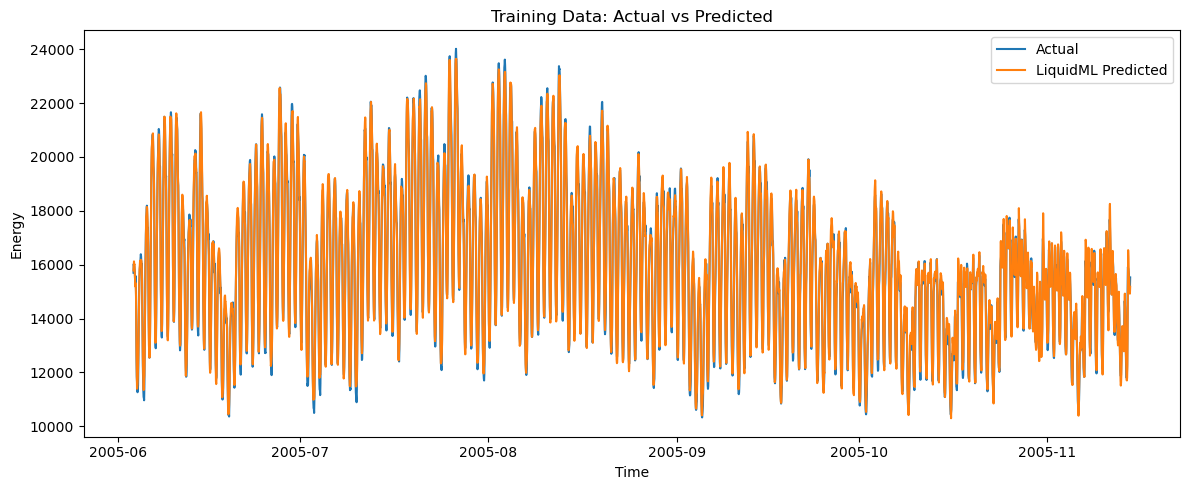

In [18]:
plt.figure(figsize=(12, 5))
plt.plot(df_train_raw.index[-len(train_pred_inv):], y_train_inv, label='Actual')
plt.plot(df_train_raw.index[-len(train_pred_inv):], train_pred_inv, label='LiquidML Predicted')
plt.title('Training Data: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
test_pred_inv = scaler.inverse_transform(test_pred.numpy())
y_test_inv = scaler.inverse_transform(y_test.numpy())
test_rmse = math.sqrt(mean_squared_error(y_test_inv, test_pred_inv))
print(f"Test RMSE: {test_rmse:.4f}")

Test RMSE: 430.7363


In [20]:
dataset_name = "Energy"
rmse_file = "RMSE_LiquidML.json"

try:
    with open(rmse_file, "r") as f:
        rmse_data = json.load(f)
except FileNotFoundError:
    rmse_data = {}

rmse_data[dataset_name] = round(test_rmse, 2)

with open(rmse_file, "w") as f:
    json.dump(rmse_data, f, indent=4)

In [21]:
pred_path = "predictions/Energy_LiquidML_test.npy"
os.makedirs("predictions", exist_ok=True)
np.save(pred_path, test_pred_inv)

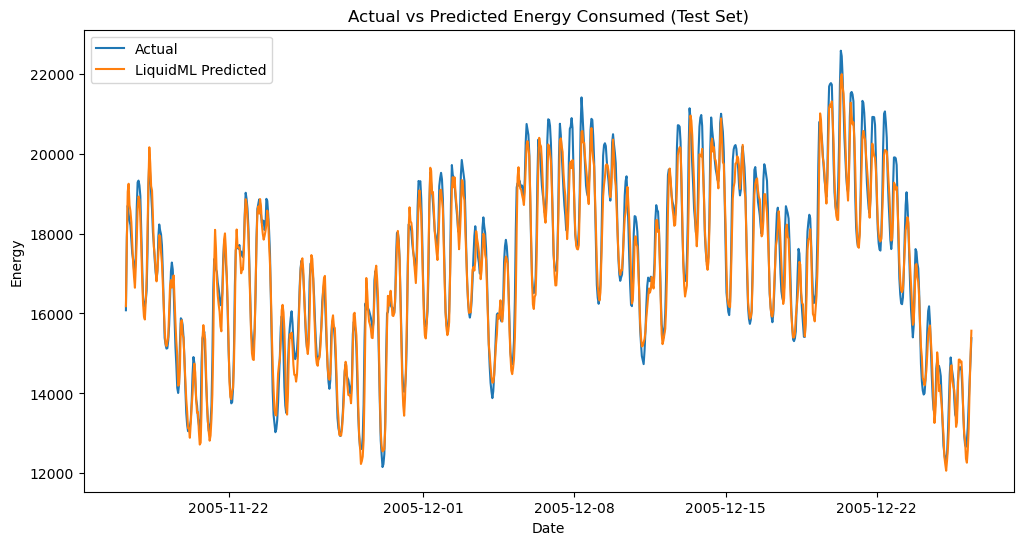

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(df_test_raw.index[-len(test_pred_inv):], y_test_inv, label='Actual')
plt.plot(df_test_raw.index[-len(test_pred_inv):], test_pred_inv, label='LiquidML Predicted')
plt.title('Actual vs Predicted Energy Consumed (Test Set)')
plt.xlabel('Date')
plt.ylabel('Energy')
plt.legend()
plt.show()